Pretraining GPT

In [103]:
import torch
import torch.nn as nn
from gpt import GPT_Model
from gpt import *
import tiktoken
from dataloader import *


In [104]:
# config dictionary
GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "embedding_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "dropout_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

In [105]:
torch.manual_seed(123)
model = GPT_Model(GPT_CONFIG_124M)
# model.eval()

In [106]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        
        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)
        
        # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]  

        # Apply softmax to get probabilities
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

In [107]:
# generating sample output

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you Samoa parad Defensive MacBook Referospace preparation Einstein ShepherdMot


Text Generation Loss

In [108]:
# example inputs:

inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]

In [109]:
# convert tokens into probas

with torch.no_grad():
    logits = model(inputs)

probas = torch.softmax(logits, dim=-1) # Probability of each token in vocabulary
print(probas.shape) # Shape: (batch_size, num_tokens, vocab_size)

torch.Size([2, 3, 50257])


In [110]:
# get max probability token from each row
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[ 5873],
         [42899],
         [26729]],

        [[ 9580],
         [24016],
         [16637]]])


In [111]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  percentage Skinner Theme


In [112]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([4.0361e-05, 2.7365e-05, 1.1450e-05])
Text 2: tensor([8.3060e-06, 9.1842e-05, 6.1181e-06])


In [113]:
# applying log to the probabilities
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([-10.1176, -10.5063, -11.3775, -11.6985,  -9.2954, -12.0043])


In [114]:
# average of the logs
average_log_probas = torch.mean(log_probas)
# cross entropy loss:
cross_entropy_loss = -average_log_probas
print(average_log_probas)
print(cross_entropy_loss)

tensor(-10.8333)
tensor(10.8333)


In [115]:
print("Logits: ", logits.shape)
print("Targets: ", targets.shape)

Logits:  torch.Size([2, 3, 50257])
Targets:  torch.Size([2, 3])


In [116]:
# flatten tensors
logits_flat = logits.flatten(0,1)
targets_flat = targets.flatten()
print("Logits flat: ", logits_flat.shape)
print("Targets flat: ", targets_flat.shape)

Logits flat:  torch.Size([6, 50257])
Targets flat:  torch.Size([6])


In [117]:
# cross entropy loss
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.8333)


In [118]:
# exponential of loss = perplexity
perplexity = torch.exp(loss)
print(perplexity)

tensor(50679.5469)


Loss for training & validation dataset

In [119]:
# load dataset file
file_path = "the-verdict.txt"
with open(file_path, "r", encoding="utf-8") as file:
    text = file.read()

total_chars = len(text)
total_tokens = len(tokenizer.encode(text))
print("Total characters: ", total_chars)
print("Total tokens: ", total_tokens)


Total characters:  20479
Total tokens:  5145


In [120]:
# splitting text data into training and validation sets
# data is split into chunks, and then batched for training

train_ratio = 0.9
val_ratio = 0.1
split_idx = int(len(text) * train_ratio)
print("Split index: ", split_idx)
train_text = text[:split_idx]
val_text = text[split_idx:]

Split index:  18431


In [121]:

torch.manual_seed(123)

train_loader = create_dataloader_1(
    train_text,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_1(
    val_text,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [122]:
# check the data loaders
print("Train loader: ", len(train_loader))
for x,y in train_loader:
    print(x.shape, y.shape)

print("Validation loader: ", len(val_loader))
for x,y in val_loader:
    print(x.shape, y.shape)

Train loader:  9
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
Validation loader:  1
torch.Size([2, 256]) torch.Size([2, 256])


In [123]:
# function to calculate cross entropy loss for a batch
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss

In [124]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            # sum up loss for each batch
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches # average loss of all batches

In [125]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


if torch.cuda.is_available():
   device = torch.device("cuda")
elif torch.backends.mps.is_available():
   device = torch.device("mps")
else:
   device = torch.device("cpu")

print(f"Using {device} device.")

model.to(device)
torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Using mps device.
Training loss: 10.989204936557346
Validation loss: 10.980826377868652


In [126]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [127]:

def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

Training the LLM

In [128]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(model, tokenizer, device, start_context)

    return train_losses, val_losses, track_tokens_seen

In [129]:
# 10 epochs of training
torch.manual_seed(123)
model = GPT_Model(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)


Ep 1 (Step 000000): Train loss 9.818, Val loss 9.925
Ep 1 (Step 000005): Train loss 8.067, Val loss 8.334
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train loss 6.620, Val loss 7.043
Ep 2 (Step 000015): Train loss 6.046, Val loss 6.596
Every effort moves you, and,, and, and,,,,, and, and,,,,,,,,,,, and,, the,, the, and,, and,,, the, and,,,,,,
Ep 3 (Step 000020): Train loss 5.524, Val loss 6.507
Ep 3 (Step 000025): Train loss 5.370, Val loss 6.378
Every effort moves you, and to the of the of the picture. Gis.                                     
Ep 4 (Step 000030): Train loss 4.834, Val loss 6.263
Ep 4 (Step 000035): Train loss 4.590, Val loss 6.285
Every effort moves you of the "I the picture.                    "I"I the picture"I had the picture"I the picture and I had been the picture of
Ep 5 (Step 000040): Train loss 3.885, Val loss 6.131
Every effort moves you know he had been his pictures, and I felt it's by his last word.          

Plotting Loss Curves

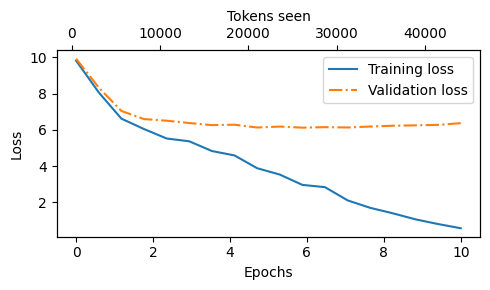

In [130]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# plotting loss curves

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

   
    ax2 = ax1.twiny() 
    ax2.plot(tokens_seen, train_losses, alpha=0) 
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    # plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

Improve Text Generation & Reduce Data Memorization

In [131]:
model.to("cpu")
model.eval()

GPT_Model(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_projection): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): Gelu()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_f

In [132]:
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"




Temperature Scaling

In [133]:
# adds a probabilistic selection for the next token

# here is argmax (greedy decoding) method
vocab = { 
    "closer": 0,
    "every": 1, 
    "effort": 2, 
    "forward": 3,
    "inches": 4,
    "moves": 5, 
    "pizza": 6,
    "toward": 7,
    "you": 8,
}
inverse_vocab = {v: k for k, v in vocab.items()}

next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()
# The next generated token is then as follows:
print(inverse_vocab[next_token_id])

forward


In [152]:
# probabilistic sampling approach

torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

forward


In [154]:
# divide logits by a number greater than 0 to scale the logits

def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

# Temperature values
temperatures = [1, 0.1, 5]  # Original, higher confidence, and lower confidence

# Calculate scaled probabilities
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]
print(scaled_probas)

[tensor([6.0907e-02, 1.6313e-03, 1.0019e-04, 5.7212e-01, 3.4190e-03, 1.3257e-04,
        1.0120e-04, 3.5758e-01, 4.0122e-03]), tensor([1.8530e-10, 3.5189e-26, 2.6890e-38, 9.9099e-01, 5.7569e-23, 4.4220e-37,
        2.9718e-38, 9.0133e-03, 2.8514e-22]), tensor([0.1546, 0.0750, 0.0429, 0.2421, 0.0869, 0.0454, 0.0430, 0.2203, 0.0898])]


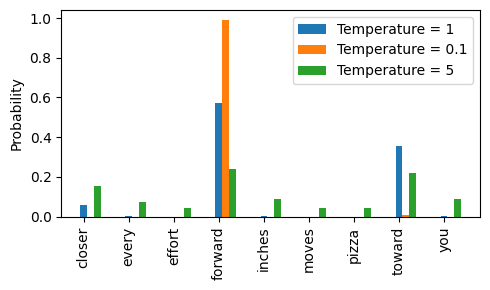

In [155]:
# Plotting
x = torch.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f'Temperature = {T}')

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()

plt.tight_layout()
# plt.savefig("temperature-plot.pdf")
plt.show()

<!-- Top K Sampling -->

Top K Sampling

In [156]:
# mask the non-top-k logits
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)

print("Top logits:", top_logits)
print("Top positions:", top_pos)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


In [157]:
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],
    # masking the non-top-k logits with -inf
    input=torch.tensor(float("-inf")), 
    other=next_token_logits
)

print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [158]:
# applying softmax to the unmasked logits
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


In [159]:
# new text generating function

def generate_text(model, idx, max_new_tokens, context_size, temp=0.0, top_k=None, eos_id=None):
    
    # Only last time step logits are used
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)


        # Apply temperature scaling, control randomness
        if temp > 0.0:
            logits = logits / temp

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)

        # get idx of the tokens with the highest probability
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)

        if idx_next == eos_id:  # Stop generating early if end of sequence is reached
            break

        # append predicted token idx
        idx = torch.cat((idx, idx_next), dim=1)

    return idx


In [173]:
torch.manual_seed(123)

token_ids = generate_text(
    model=model,
    idx=text_to_token_ids("First time pre-training GPT on small data is a", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=5,
    temp=0.5
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 First time pre-training GPT on small data is a straw--though a good fellow enough--so it was no great surprise to


Saving the Model

In [174]:
# torch.save(model.state_dict(), "model.pth")